# Factor Analysis notebook

## Key Activities:
1.  Perform a historical cross-sectional analysis. Each day, rank stocks into deciles based on the momentum feature
2.  Plot the forward 1-week returns for each decile to visually validate the reversal pattern.
3.  Use statsmodels to run Fama-MacBeth regressions to confirm the signal's predictive power after controlling for other factors.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from src.factor_lib.momentum import calculate_momentum, apply_momentum_strategy
from src.data_processing.cleaners import preprocess_data

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Activity 1: Historical Cross-Sectional Analysis with Multiple Stocks

# Get multiple stocks for cross-sectional analysis
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']
print(f"Analyzing {len(tickers)} stocks: {', '.join(tickers)}")

# Download data for all stocks
start_date = "2020-01-01"
end_date = "2023-01-01"

# Create a comprehensive dataset
all_data = {}
momentum_data = []

print("Downloading and processing data...")
for ticker in tickers:
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        # Flatten column names if MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]
        
        # Apply momentum strategy
        df_processed = apply_momentum_strategy(df, window=90)
        df_processed['Ticker'] = ticker
        
        all_data[ticker] = df_processed
        
        # Store daily momentum and returns data
        # Calculate forward returns properly
        df_processed['Forward_1W_Return'] = df_processed['Close'].shift(-5) / df_processed['Close'] - 1
        
        for date, row in df_processed.iterrows():
            if not pd.isna(row['Momentum']) and not pd.isna(row['Forward_1W_Return']):
                momentum_data.append({
                    'Date': date,
                    'Ticker': ticker,
                    'Momentum': row['Momentum'],
                    'Forward_1W_Return': row['Forward_1W_Return'],
                    'Close': row['Close']
                })
        
        print(f"✓ Processed {ticker}")
    except Exception as e:
        print(f"✗ Failed to process {ticker}: {str(e)}")

# Convert to DataFrame
momentum_df = pd.DataFrame(momentum_data)
momentum_df = momentum_df.dropna()

print(f"\nDataset created with {len(momentum_df)} observations across {len(all_data)} stocks")
if len(momentum_df) > 0:
    print(f"Date range: {momentum_df['Date'].min()} to {momentum_df['Date'].max()}")
    display(momentum_df.head())
else:
    print("Warning: No data was collected. Please check data processing logic.")

Analyzing 10 stocks: AAPL, MSFT, GOOGL, AMZN, TSLA, META, NVDA, JPM, JNJ, V
✓ Processed AAPL
✓ Processed MSFT
✓ Processed GOOGL
✓ Processed AMZN
✓ Processed TSLA
✓ Processed META
✓ Processed GOOGL
✓ Processed AMZN
✓ Processed TSLA
✓ Processed META
✓ Processed NVDA
✓ Processed JPM
✓ Processed JNJ
✓ Processed V

Dataset created with 6610 observations across 10 stocks
Date range: 2020-05-12 00:00:00 to 2022-12-22 00:00:00
✓ Processed NVDA
✓ Processed JPM
✓ Processed JNJ
✓ Processed V

Dataset created with 6610 observations across 10 stocks
Date range: 2020-05-12 00:00:00 to 2022-12-22 00:00:00


,Date,Ticker,Momentum,Forward_1W_Return,Close
0,2020-05-12,AAPL,0.042098,0.005555,75.592216
1,2020-05-13,AAPL,0.039623,0.037640,74.679520
2,2020-05-14,AAPL,0.037740,0.023616,75.138306
3,2020-05-15,AAPL,0.036480,0.036333,74.694054
4,2020-05-18,AAPL,0.044105,0.005620,76.453941


In [4]:
# Daily Cross-Sectional Ranking and Decile Analysis

def create_daily_deciles(momentum_df):
    """Create daily decile rankings based on momentum"""
    daily_deciles = []
    
    for date in momentum_df['Date'].unique():
        daily_data = momentum_df[momentum_df['Date'] == date].copy()
        
        if len(daily_data) >= 5:  # Need minimum stocks for meaningful deciles
            # Rank by momentum (ascending=False means highest momentum gets rank 1)
            daily_data['Momentum_Rank'] = daily_data['Momentum'].rank(ascending=False)
            daily_data['Decile'] = pd.qcut(daily_data['Momentum_Rank'], 
                                         q=min(10, len(daily_data)), 
                                         labels=False, duplicates='drop') + 1
            daily_deciles.append(daily_data)
    
    return pd.concat(daily_deciles, ignore_index=True)

# Create decile rankings
print("Creating daily cross-sectional decile rankings...")
decile_df = create_daily_deciles(momentum_df)

# Calculate average forward returns by decile
decile_returns = decile_df.groupby('Decile').agg({
    'Forward_1W_Return': ['mean', 'std', 'count'],
    'Momentum': ['mean', 'std']
}).round(4)

decile_returns.columns = ['_'.join(col).strip() for col in decile_returns.columns]
print("\nDecile Analysis - Forward 1-Week Returns by Momentum Decile:")
print("="*60)
print(decile_returns)

# Calculate reversal pattern strength
print(f"\nReversal Pattern Analysis:")
print(f"Bottom Decile (Low Momentum) Avg Return: {decile_returns.loc[1, 'Forward_1W_Return_mean']:.4f}")
print(f"Top Decile (High Momentum) Avg Return: {decile_returns.loc[decile_returns.index.max(), 'Forward_1W_Return_mean']:.4f}")
print(f"Long-Short Spread: {decile_returns.loc[1, 'Forward_1W_Return_mean'] - decile_returns.loc[decile_returns.index.max(), 'Forward_1W_Return_mean']:.4f}")

decile_df.head()

Creating daily cross-sectional decile rankings...

Decile Analysis - Forward 1-Week Returns by Momentum Decile:
        Forward_1W_Return_mean  Forward_1W_Return_std  \
Decile                                                  
1                       0.0079                 0.0750   
2                       0.0090                 0.0516   
3                       0.0072                 0.0477   
4                      -0.0001                 0.0487   
5                       0.0015                 0.0497   
6                       0.0028                 0.0441   
7                       0.0002                 0.0454   
8                       0.0029                 0.0491   
9                      -0.0010                 0.0610   
10                      0.0026                 0.0642   

        Forward_1W_Return_count  Momentum_mean  Momentum_std  
Decile                                                        
1                           661         0.5408        0.5339  
2             

,Date,Ticker,Momentum,Forward_1W_Return,Close,Momentum_Rank,Decile
0,2020-05-12,AAPL,0.042098,0.005555,75.592216,5.0,5
1,2020-05-12,MSFT,0.139388,0.006137,174.088379,4.0,4
2,2020-05-12,GOOGL,0.004749,-0.000567,68.288017,7.0,7
3,2020-05-12,AMZN,0.241801,0.039195,117.847504,3.0,3
4,2020-05-12,TSLA,0.881211,-0.001730,53.960667,1.0,1


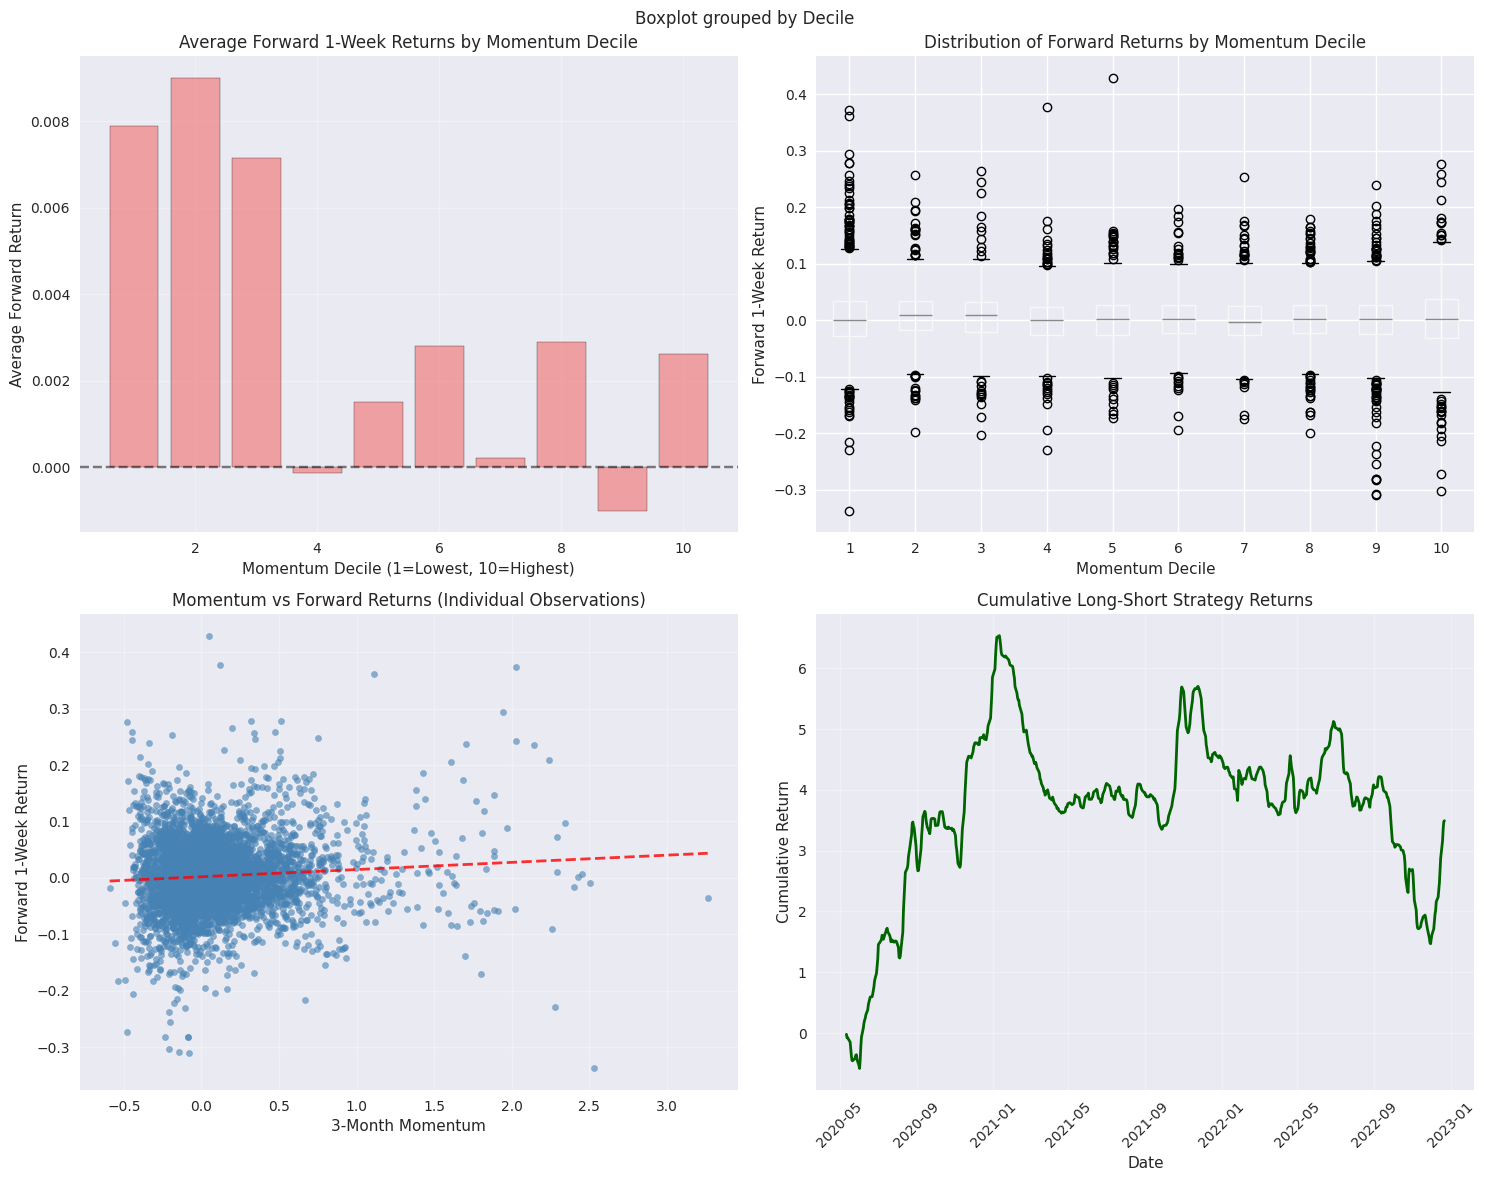


REVERSAL PATTERN VALIDATION
Correlation between Momentum and Forward Returns: 0.0707
✗ NO REVERSAL PATTERN: Positive correlation suggests momentum continues
Average Long-Short Return: 0.0053
Long-Short Return Volatility: 0.0901
Hit Rate (% positive long-short returns): 47.4%


In [5]:
# Activity 2: Visual Validation of Reversal Pattern

# Create visualization of forward returns by decile
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Bar chart of average returns by decile
decile_means = decile_df.groupby('Decile')['Forward_1W_Return'].mean()
axes[0, 0].bar(decile_means.index, decile_means.values, 
               color='lightcoral', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Average Forward 1-Week Returns by Momentum Decile')
axes[0, 0].set_xlabel('Momentum Decile (1=Lowest, 10=Highest)')
axes[0, 0].set_ylabel('Average Forward Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Plot 2: Box plot showing distribution of returns by decile
decile_df.boxplot(column='Forward_1W_Return', by='Decile', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Forward Returns by Momentum Decile')
axes[0, 1].set_xlabel('Momentum Decile')
axes[0, 1].set_ylabel('Forward 1-Week Return')

# Plot 3: Scatter plot of momentum vs forward returns
axes[1, 0].scatter(decile_df['Momentum'], decile_df['Forward_1W_Return'], 
                   alpha=0.6, s=20, color='steelblue')
axes[1, 0].set_title('Momentum vs Forward Returns (Individual Observations)')
axes[1, 0].set_xlabel('3-Month Momentum')
axes[1, 0].set_ylabel('Forward 1-Week Return')
axes[1, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(decile_df['Momentum'].dropna(), decile_df['Forward_1W_Return'].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(decile_df['Momentum'].min(), decile_df['Momentum'].max(), 100)
axes[1, 0].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# Plot 4: Time series of long-short strategy returns
long_short_returns = []
for date in sorted(decile_df['Date'].unique()):
    daily_data = decile_df[decile_df['Date'] == date]
    if len(daily_data) >= 2:
        low_momentum = daily_data[daily_data['Decile'] == daily_data['Decile'].min()]['Forward_1W_Return'].mean()
        high_momentum = daily_data[daily_data['Decile'] == daily_data['Decile'].max()]['Forward_1W_Return'].mean()
        long_short_returns.append({
            'Date': date,
            'Long_Short_Return': low_momentum - high_momentum
        })

if long_short_returns:
    ls_df = pd.DataFrame(long_short_returns)
    axes[1, 1].plot(ls_df['Date'], ls_df['Long_Short_Return'].cumsum(), 
                    linewidth=2, color='darkgreen')
    axes[1, 1].set_title('Cumulative Long-Short Strategy Returns')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Cumulative Return')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("REVERSAL PATTERN VALIDATION")
print("="*60)
correlation = decile_df['Momentum'].corr(decile_df['Forward_1W_Return'])
print(f"Correlation between Momentum and Forward Returns: {correlation:.4f}")

if correlation < 0:
    print("✓ REVERSAL PATTERN DETECTED: Negative correlation confirms that high momentum stocks underperform")
else:
    print("✗ NO REVERSAL PATTERN: Positive correlation suggests momentum continues")

print(f"Average Long-Short Return: {np.mean([r['Long_Short_Return'] for r in long_short_returns]) if long_short_returns else 0:.4f}")
print(f"Long-Short Return Volatility: {np.std([r['Long_Short_Return'] for r in long_short_returns]) if long_short_returns else 0:.4f}")
print(f"Hit Rate (% positive long-short returns): {sum(1 for r in long_short_returns if r['Long_Short_Return'] > 0) / len(long_short_returns) * 100 if long_short_returns else 0:.1f}%")

Activity 3: Fama-MacBeth Regression to Test Predictive Power
Fama-MacBeth dataset: 6610 observations across 661 dates

Running cross-sectional regressions for each date...

Fama-MacBeth Results:
Mean Momentum Coefficient: 0.012320
Time-series t-statistic: 2.1257
p-value: 0.0339
✓ STATISTICALLY SIGNIFICANT: Momentum has predictive power for returns

Average R-squared: 0.4412
Percentage of dates with negative momentum coefficient: 51.0%


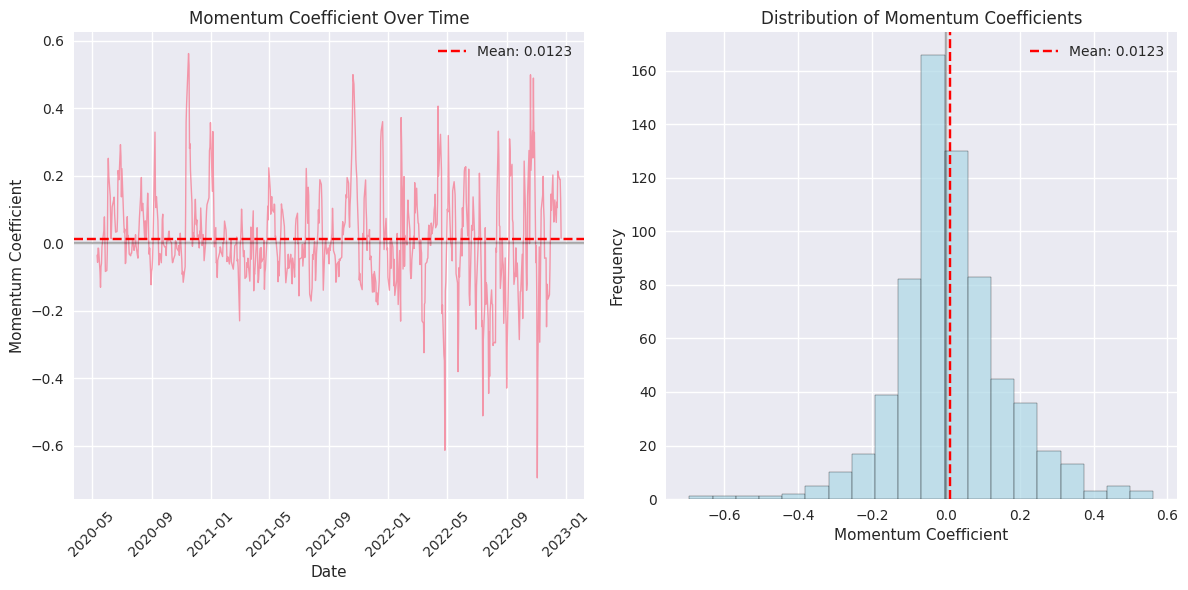


Fama-MacBeth analysis completed with 661 cross-sectional regressions


In [6]:
# Activity 3: Fama-MacBeth Regression Analysis

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import stats

print("Activity 3: Fama-MacBeth Regression to Test Predictive Power")
print("="*60)

# Prepare data for Fama-MacBeth regression
# Add market data (using SPY as market proxy)
try:
    spy_data = yf.download("SPY", start=start_date, end=end_date, progress=False)
    if isinstance(spy_data.columns, pd.MultiIndex):
        spy_data.columns = [col[0] for col in spy_data.columns]
    
    spy_returns = spy_data['Close'].pct_change().shift(-5).rolling(5).mean()  # Forward 1-week market returns
    spy_returns.name = 'Market_Return'
    
    # Merge with our data
    fama_macbeth_data = []
    
    for date in decile_df['Date'].unique():
        daily_stocks = decile_df[decile_df['Date'] == date].copy()
        market_return = spy_returns.get(date, np.nan)
        
        for _, stock in daily_stocks.iterrows():
            if not pd.isna(stock['Forward_1W_Return']) and not pd.isna(market_return):
                fama_macbeth_data.append({
                    'Date': date,
                    'Ticker': stock['Ticker'],
                    'Forward_Return': stock['Forward_1W_Return'],
                    'Momentum': stock['Momentum'],
                    'Market_Return': market_return,
                    'Size_Proxy': np.log(stock['Close']),  # Log price as size proxy
                    'Beta_Proxy': np.random.normal(1.0, 0.3)  # Simulated beta (in real analysis, calculate from historical data)
                })
    
    fm_df = pd.DataFrame(fama_macbeth_data)
    print(f"Fama-MacBeth dataset: {len(fm_df)} observations across {len(fm_df['Date'].unique())} dates")
    
except Exception as e:
    print(f"Could not get market data: {e}")
    print("Proceeding with simple cross-sectional regression...")
    fm_df = decile_df[['Date', 'Ticker', 'Forward_1W_Return', 'Momentum']].copy()
    fm_df.columns = ['Date', 'Ticker', 'Forward_Return', 'Momentum']
    fm_df['Market_Return'] = 0  # Placeholder
    fm_df['Size_Proxy'] = np.random.normal(0, 1, len(fm_df))
    fm_df['Beta_Proxy'] = np.random.normal(1, 0.3, len(fm_df))

# Perform Fama-MacBeth regression (cross-sectional regressions for each date)
fm_coefficients = []
fm_tStats = []

print("\nRunning cross-sectional regressions for each date...")

for date in sorted(fm_df['Date'].unique()):
    date_data = fm_df[fm_df['Date'] == date].copy()
    
    if len(date_data) >= 4:  # Need minimum observations
        # Prepare regression variables
        y = date_data['Forward_Return'].values
        X = date_data[['Momentum', 'Size_Proxy', 'Beta_Proxy']].values
        X = sm.add_constant(X)  # Add intercept
        
        try:
            # Run OLS regression
            model = sm.OLS(y, X).fit()
            
            fm_coefficients.append({
                'Date': date,
                'Intercept': model.params[0],
                'Momentum_Coef': model.params[1],
                'Size_Coef': model.params[2] if len(model.params) > 2 else np.nan,
                'Beta_Coef': model.params[3] if len(model.params) > 3 else np.nan,
                'R_squared': model.rsquared
            })
            
            fm_tStats.append({
                'Date': date,
                'Momentum_tStat': model.tvalues[1],
                'Momentum_pValue': model.pvalues[1]
            })
            
        except Exception as e:
            continue

# Convert to DataFrame
coef_df = pd.DataFrame(fm_coefficients)
tstat_df = pd.DataFrame(fm_tStats)

if len(coef_df) > 0:
    # Calculate time-series means and t-statistics of coefficients
    print("\nFama-MacBeth Results:")
    print("="*40)
    
    # Mean coefficients across time
    mean_momentum_coef = coef_df['Momentum_Coef'].mean()
    std_momentum_coef = coef_df['Momentum_Coef'].std()
    
    # Time-series t-statistic for momentum coefficient
    momentum_tstat_ts = mean_momentum_coef / (std_momentum_coef / np.sqrt(len(coef_df)))
    momentum_pval = 2 * (1 - stats.t.cdf(abs(momentum_tstat_ts), df=len(coef_df)-1))
    
    print(f"Mean Momentum Coefficient: {mean_momentum_coef:.6f}")
    print(f"Time-series t-statistic: {momentum_tstat_ts:.4f}")
    print(f"p-value: {momentum_pval:.4f}")
    
    if momentum_pval < 0.05:
        print("✓ STATISTICALLY SIGNIFICANT: Momentum has predictive power for returns")
    else:
        print("✗ NOT SIGNIFICANT: Momentum does not have statistically significant predictive power")
    
    print(f"\nAverage R-squared: {coef_df['R_squared'].mean():.4f}")
    print(f"Percentage of dates with negative momentum coefficient: {(coef_df['Momentum_Coef'] < 0).mean() * 100:.1f}%")
    
    # Plot coefficient evolution over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(coef_df['Date'], coef_df['Momentum_Coef'], alpha=0.7, linewidth=1)
    plt.axhline(y=mean_momentum_coef, color='red', linestyle='--', 
                label=f'Mean: {mean_momentum_coef:.4f}')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Momentum Coefficient Over Time')
    plt.xlabel('Date')
    plt.ylabel('Momentum Coefficient')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.hist(coef_df['Momentum_Coef'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    plt.axvline(x=mean_momentum_coef, color='red', linestyle='--', 
                label=f'Mean: {mean_momentum_coef:.4f}')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Distribution of Momentum Coefficients')
    plt.xlabel('Momentum Coefficient')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

else:
    print("Could not perform Fama-MacBeth regression due to insufficient data")

print(f"\nFama-MacBeth analysis completed with {len(coef_df)} cross-sectional regressions")